<a href="https://colab.research.google.com/github/donaldssh/3DAR_project_descriptors/blob/autoencoder/Surf_Autoencoder_3Ddesc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is meant to be used only for **experimenting and training the model**.
The actual compression on the decriptor will be carried out by a standard python script, that uses a pretrained model.


import dataset from drive.
We are using surf 64 values now

In [1]:
#warning: this only work for Daniele drive

! unzip /content/drive/MyDrive/UNI_ICT/3DAR/dataset_autoencoder_64.zip

Archive:  /content/drive/MyDrive/UNI_ICT/3DAR/dataset_autoencoder_64.zip
  inflating: test_set_64.bin         
  inflating: train_set_64.bin        


Import libraries

In [2]:
!pip install --quiet optuna


     |████████████████████████████████| 266kB 7.8MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 163kB 14.1MB/s 
     |████████████████████████████████| 81kB 8.3MB/s 
     |████████████████████████████████| 81kB 8.7MB/s 
     |████████████████████████████████| 51kB 6.8MB/s 
     |████████████████████████████████| 133kB 15.4MB/s 
     |████████████████████████████████| 112kB 11.3MB/s 


In [3]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm import notebook, tqdm # this module is useful to plot progress bars
from sklearn.decomposition import PCA
# import json
# import numba

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
from torchvision import transforms
import torchvision
import optuna

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")
torch.manual_seed(0)

Training device: cuda


load binary file with descriptor as dataframe

In [5]:
train_path = '/content/train_set_64.bin'
test_path = '/content/test_set_64.bin'

train_raw = np.fromfile(train_path, dtype='float32')
test_raw = np.fromfile(test_path, dtype='float32')
print(np.shape(train_raw), np.shape(test_raw))

train_set = np.reshape(train_raw, (np.shape(train_raw)[0]//64,64))
test_set = np.reshape(test_raw, (np.shape(test_raw)[0]//64,64))
print(np.shape(train_set), np.shape(test_set))

# convert in dataframe
train_set = pd.DataFrame(train_set)
test_set = pd.DataFrame(test_set)
train_set

(46288128,) (75180800,)
(723252, 64) (1174700, 64)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63
0,0.004407,0.001996,0.004554,0.003585,0.000658,0.002856,0.005254,0.020954,-0.000037,0.008043,0.002896,0.019779,0.000181,0.001629,0.001409,0.002848,0.008377,0.018547,0.027191,0.021811,-0.171450,-0.102450,0.265709,0.296752,0.199912,-0.106352,0.239787,0.271681,-0.030724,0.000752,0.035426,0.022045,0.027830,-0.016565,0.047988,0.029676,-0.315193,-0.032321,0.390159,0.115368,0.370034,0.060102,0.424093,0.094829,-0.032906,0.000457,0.042881,0.012940,-0.000612,-0.007984,0.003958,0.011167,0.008017,-0.020286,0.029766,0.068834,0.029607,-0.006064,0.035976,0.047604,-0.003587,-0.003266,0.009080,0.004765
1,-0.003536,-0.000899,0.003937,0.000953,0.014653,0.022780,0.015201,0.025493,-0.000738,0.041573,0.013557,0.046297,-0.000336,-0.001742,0.001951,0.003649,-0.020310,-0.000678,0.023190,0.005122,0.363240,0.079607,0.369027,0.080848,-0.095946,0.190492,0.156787,0.198567,-0.006962,0.037377,0.015309,0.039203,-0.021338,0.002288,0.021813,0.003379,0.329178,-0.070078,0.355630,0.183020,-0.106004,-0.293261,0.287802,0.373284,-0.002777,-0.015840,0.010511,0.019472,-0.003453,-0.000053,0.003719,0.000851,0.035446,-0.016061,0.035949,0.026542,-0.011818,0.007160,0.025521,0.028424,0.000554,-0.004372,0.001171,0.005567
2,0.009644,0.001529,0.009644,0.004456,0.023019,-0.009848,0.032693,0.020424,-0.001789,0.025646,0.021495,0.029584,-0.012570,0.008274,0.013059,0.008841,0.020649,0.037412,0.050575,0.052041,-0.073895,-0.118788,0.318967,0.366973,0.255595,-0.202257,0.262245,0.239301,-0.017392,0.006626,0.025969,0.024555,0.007550,-0.019084,0.046358,0.049074,-0.090525,0.107472,0.230360,0.339816,0.245707,0.198693,0.328900,0.271376,-0.008979,0.001402,0.012592,0.014513,-0.001086,-0.001319,0.002458,0.005561,-0.005253,-0.044045,0.026936,0.061142,0.031942,-0.082045,0.038574,0.084142,0.002822,-0.004524,0.002922,0.004601
3,0.004933,0.001614,0.005432,0.002594,0.006627,0.008386,0.010936,0.033493,0.000318,0.006081,0.004224,0.022614,0.000120,0.001404,0.000646,0.003463,0.047695,0.009608,0.059088,0.032129,-0.212262,-0.059219,0.352559,0.250547,0.196748,-0.061317,0.344205,0.233035,-0.001644,-0.000155,0.028374,0.014749,0.016633,-0.013260,0.032813,0.026604,-0.166119,-0.144965,0.359705,0.235879,0.257067,0.012592,0.441853,0.186932,0.023218,0.004029,0.024523,0.019002,-0.002909,-0.004061,0.003658,0.004373,0.013850,0.007489,0.015463,0.032104,0.014343,-0.002371,0.037800,0.045044,0.006889,-0.002155,0.007436,0.005978
4,-0.000324,0.001745,0.009577,0.003259,-0.019881,0.001922,0.027535,0.003389,0.003554,-0.001029,0.007110,0.008067,-0.001168,0.003987,0.001192,0.003987,0.043044,-0.001200,0.054460,0.034623,-0.009974,0.182615,0.341453,0.211402,0.020366,0.264695,0.336762,0.282833,-0.045841,0.006495,0.045841,0.008763,0.045545,-0.009615,0.055308,0.019326,0.163498,-0.053805,0.547286,0.127313,-0.149741,-0.070161,0.346120,0.137879,-0.037873,0.007815,0.044718,0.012359,0.006307,0.000254,0.006313,0.001666,0.019324,-0.006782,0.068941,0.031453,-0.006571,-0.001735,0.043383,0.025357,-0.003769,0.000540,0.004506,0.001386
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
723247,0.005034,-0.012831,0.005158,0.013512,0.063448,-0.003992,0.066175,0.010695,-0.008170,-0.005302,0.009573,0.007653,-0.020659,-0.000220,0.021006,0.000451,0.042491,0.024491,0.044070,0.030834,0.442431,0.020103,0.477397,0.029985,-0.071589,0.012536,0.078032,0.042112,-0.143973,-0.005998,0.146557,0.009311,0.021705,0.002268,0.030992,0.004847,0.440180,-0.013247,0.475578,0.040831,-0.105145,-0.023517,0.113144,0.048342,-0.145537,0.002640,0.147697,0.035030,0.002070,0.000197,0.003035,0.001053,0.063883,-0.003410,0.068948,0.008078,-0.009452,0.003005,0.010598,0.005187,-0.020435,-0.000143,0.0207

# Analysis on the descriptors structure

Knowing the SURF algorithm, can we find regularities and exploit them for the design of a more efficient autoencoder?

opencv implementation about the writing of the 64 bin descriptor.
From https://github.com/opencv/opencv_contrib/blob/master/modules/xfeatures2d/src/surf.cpp at line 795

```

// 64-bin descriptor
for( i = 0; i < 4; i++ )
    for( j = 0; j < 4; j++ )
    {
        for(int y = i*5; y < i*5+5; y++ )
        {
            for(int x = j*5; x < j*5+5; x++ )
            {
                float tx = DX[y][x], ty = DY[y][x];
                vec[0] += tx; vec[1] += ty;
                vec[2] += (float)fabs(tx); vec[3] += (float)fabs(ty);
            }
        }
        for( kk = 0; kk < 4; kk++ )
            square_mag += vec[kk]*vec[kk];
        vec+=4;
    }
            

```



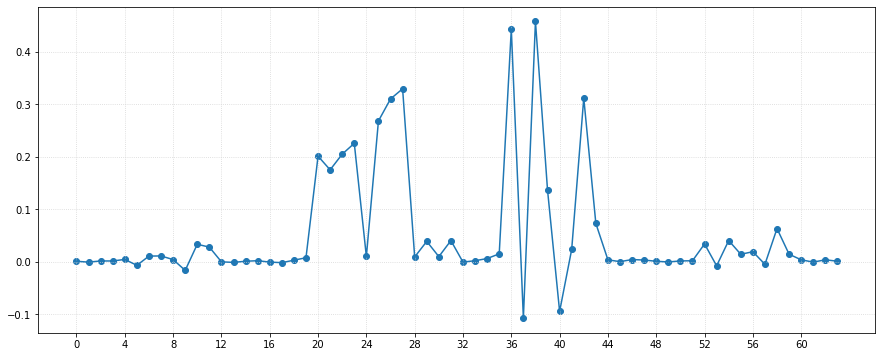

In [6]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_xticks(np.arange(0,64,4))
ax.scatter(range(64),train_set.iloc[10,:])
ax.plot(range(64), train_set.iloc[10,:])
ax.grid(color='lightgray', linestyle=':')

Visualize the superposition of many random chosen descriptors

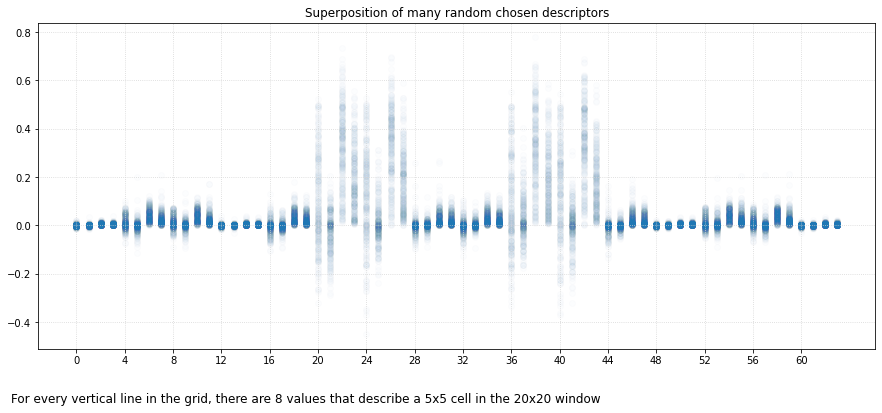

In [7]:

fig, ax = plt.subplots(figsize=(15,6))

for i in range(300):
    n = int(np.ceil(np.random.uniform()*len(train_set)))
    # ax.plot(range(64), train_set.iloc[n,:], alpha=0.01, color='#1f77b4')
    ax.scatter(range(64), train_set.iloc[n,:], alpha=0.01, color='#1f77b4')
    ax.set_xticks(np.arange(0,64,4))
    ax.grid(color='lightgray', linestyle=':')
ax.set_title("Superposition of many random chosen descriptors")
plt.figtext(0.1,0,'For every vertical line in the grid, there are 8 values that describe a 5x5 cell in the 20x20 window', fontsize = 12)
plt.show()

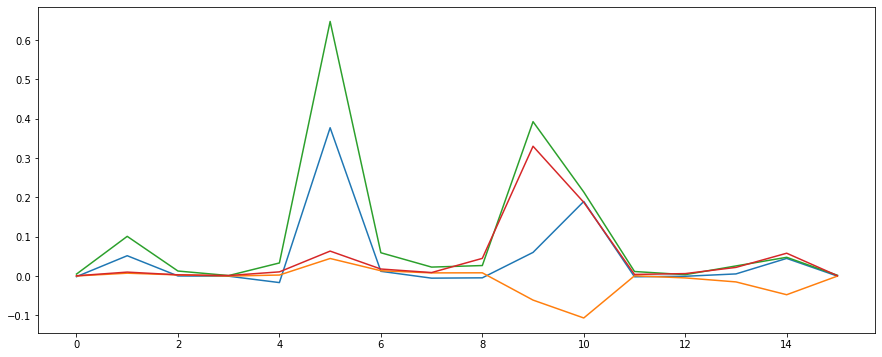

In [8]:
fig, ax = plt.subplots(figsize=(15,6))

for i in range(1):
    n = int(np.ceil(np.random.uniform()*len(train_set)))
    # ax.plot(range(128), train_set.iloc[n,:], alpha=0.01, color='#1f77b4')
    sample = train_set.iloc[n,:].to_numpy().reshape(16,4)
    ax.plot(sample)


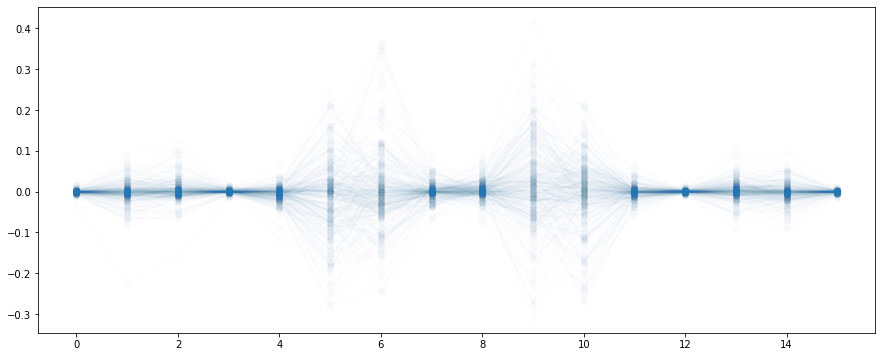

In [9]:
fig, ax = plt.subplots(figsize=(15,6))

for i in range(300):
    n = int(np.ceil(np.random.uniform()*len(train_set)))
    ax.plot(range(64//4), train_set.iloc[n,1:65:4], alpha=0.01, color='#1f77b4')
    ax.scatter(range(64//4), train_set.iloc[n,1:65:4], alpha=0.01, color='#1f77b4')


# Dataset preparation

normalize transformation class

In [10]:
class NpToTensor():
    def __call__(self, array):
        return torch.from_numpy(array)


reshaping 3D

In [11]:
class Surf3DReshape():
    def __call__(self, desc):
        channels = []
        for i in range(4):
            channels.append(np.reshape(desc[i:64:4], (4,4)))
        channels = np.dstack(channels)
        channels = np.transpose(channels, (2,0,1))
        return channels


In [12]:
print(np.max(train_raw), np.min(train_raw))
print(np.max(test_raw), np.min(test_raw))

0.91152126 -0.5377276
0.9221333 -0.54942125


Define descriptor dataset class

In [14]:
class SurfDataset(Dataset):

    def __init__(self, data, transform=None):
        self.transform = transform
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        #return a nparray from the dataframe
        sample = self.data.iloc[idx,:].to_numpy()
        if self.transform:
            sample = self.transform(sample)
        return sample

composed_transform = transforms.Compose([Surf3DReshape(), NpToTensor()])
to_tensor = NpToTensor()



Use both the transformation if we need the dataset reshaped for a convolutional AE

In [21]:
train3D_dataset = SurfDataset(train_set, transform=composed_transform)
test3D_dataset = SurfDataset(test_set, transform=composed_transform)

print(np.shape(train3D_dataset.__getitem__(100)))

train3D_dataset, val3D_dataset = random_split(train3D_dataset, [int(0.8*len(train3D_dataset)), len(train3D_dataset)-int(0.8*len(train3D_dataset))])

print(len(train3D_dataset), len(val3D_dataset))

torch.Size([4, 4, 4])
578601 144651


Use just the tensor transformation for when we use a fully connected linear AE

In [16]:
trainLin_dataset = SurfDataset(train_set, transform=to_tensor)
testLin_dataset = SurfDataset(test_set, transform=to_tensor)

print(np.shape(trainLin_dataset.__getitem__(100)))

trainLin_dataset, valLin_dataset = random_split(trainLin_dataset, [int(0.8*len(trainLin_dataset)), len(trainLin_dataset)-int(0.8*len(trainLin_dataset))])

torch.Size([64])


# Autoencoder models

## Convolutional model

In [17]:
class EncoderConv(nn.Module):
    
    def __init__(self, encoded_space_dim, conv1_ch, conv2_ch, conv3_ch, fc_ch):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(4, conv1_ch, 3, stride=1, padding=1),
            nn.ReLU(True),
            # Second convolutional layer
            nn.Conv2d(conv1_ch, conv2_ch, 3, stride=1, padding=1),
            nn.ReLU(True),
            # Third convolutional layer
            nn.Conv2d(conv2_ch, conv3_ch, 3, stride=1, padding=0),  #make it 3x3
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)

        ### Linear section
        self.encoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(2 * 2 * conv3_ch, fc_ch),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(fc_ch, encoded_space_dim)
        )
        
    def forward(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        # print(np.shape(x))
        x = self.flatten(x)
        # # Apply linear layers
        x = self.encoder_lin(x)
        return x


class DecoderConv(nn.Module):
    
    def __init__(self, encoded_space_dim, conv1_ch, conv2_ch, conv3_ch, fc_ch):
        super().__init__()

        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(encoded_space_dim, fc_ch),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(fc_ch, 2 * 2 * conv3_ch),
            nn.ReLU(True)
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(conv3_ch, 2, 2))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(conv3_ch, conv2_ch, 3, stride=1, output_padding=0),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(conv2_ch, conv1_ch, 3, stride=1, padding=1, output_padding=0),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(conv1_ch, 4, 3, stride=1, padding=1, output_padding=0)
        )
        
    def forward(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Unflatten
        x = self.unflatten(x)
        # print(np.shape(x))
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # # Apply a sigmoid to force the output to be between 0 and 1 
        # x = torch.sigmoid(x)
        return x


#debug dimension
encoder = EncoderConv(2, 16, 32,64, 50)
decoder = DecoderConv(2, 16, 32,64, 50)

sample = train3D_dataset.__getitem__(10).unsqueeze(0)
print(np.shape(sample))

output = decoder(encoder(sample))
print(np.shape(output))

torch.Size([1, 4, 4, 4])
torch.Size([1, 4, 4, 4])


## Linear model

In [18]:
class EncoderLin(nn.Module):
    
    def __init__(self, encoded_space_dim, fc1_ch, fc2_ch, fc3_ch, fc4_ch):
        super().__init__()

        ### Linear section
        self.encoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(64, fc1_ch),
            nn.ReLU(True),
            # nn.BatchNorm1d(fc1_ch)
            # Second linear layer
            nn.Linear(fc1_ch, fc2_ch),
            nn.ReLU(True),
            # Third linear level
            nn.Linear(fc2_ch, fc3_ch),
            nn.ReLU(True),
            nn.Linear(fc3_ch, fc4_ch),
            nn.ReLU(True),
            nn.Linear(fc4_ch, encoded_space_dim)
        )
        
    def forward(self, x):
        # Apply linear layers
        x = self.encoder_lin(x)
        return x


class DecoderLin(nn.Module):
    
    def __init__(self, encoded_space_dim, fc1_ch, fc2_ch, fc3_ch, fc4_ch):
        super().__init__()

        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(encoded_space_dim, fc4_ch),
            nn.ReLU(True),
            nn.Linear(fc4_ch, fc3_ch),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(fc3_ch, fc2_ch),
            nn.ReLU(True),
            nn.Linear(fc2_ch, fc1_ch),
            nn.ReLU(True),
            nn.Linear(fc1_ch, 64)
        )
        
    def forward(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        return x

# Training preparation

In [19]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for surf_batch in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        surf_batch = surf_batch.to(device)
        # Encode data
        encoded_data = encoder(surf_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, surf_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        # print('\t partial train loss (single batch): %f' % (loss.data))
    
    return loss.data

### Test/valuation function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for surf_batch in dataloader:
            # Move tensor to the proper device
            surf_batch = surf_batch.to(device)
            # Encode data
            encoded_data = encoder(surf_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(surf_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

# Parameters search with Optuna

## trying 16 dimension latent space
Search for the best hyperparameters using a 16 dimension latent space, it also try both Linear and Convolutional models

In [20]:
def objective(trial):

    #suggest parameters
    # encoded_space_dim = trial.suggest_int('encoded_space_dim', 2,10)
    encoded_space_dim = 16
    batch_size = trial.suggest_int('batch_size', 100, 600)
    architecture = trial.suggest_categorical('architecture', ['Linear', 'Conv'])
    conv1_ch = trial.suggest_int('conv1_ch', 32, 128)
    conv2_ch = trial.suggest_int('conv2_ch', 32,128)
    conv3_ch = trial.suggest_int('conv3_ch', 32,128)
    fc_ch = trial.suggest_int('fc_ch', 32,128)

    num_epochs = 50 
    
    # initialize models
    if architecture == 'Conv':
        encoder = EncoderConv(encoded_space_dim, conv1_ch, conv2_ch, conv3_ch, fc_ch)
        decoder = DecoderConv(encoded_space_dim, conv1_ch, conv2_ch, conv3_ch, fc_ch)
        
        train_dataloader = DataLoader(train3D_dataset_reduced, batch_size=batch_size, shuffle=True)
        val_dataloader = DataLoader(val3D_dataset_reduced, batch_size=batch_size, shuffle=False)

    elif architecture == 'Linear':
        encoder = EncoderLin(encoded_space_dim, conv1_ch*9, conv2_ch*9, conv3_ch*9, fc_ch*9)
        decoder = DecoderLin(encoded_space_dim, conv1_ch*9, conv2_ch*9, conv3_ch*9, fc_ch*9)

        train_dataloader = DataLoader(trainLin_dataset_reduced, batch_size=batch_size, shuffle=True)
        val_dataloader = DataLoader(valLin_dataset_reduced, batch_size=batch_size, shuffle=False)



    ### Define the loss function
    loss_fn = torch.nn.MSELoss()

    ### Define an optimizer (both for the encoder and the decoder!)
    lr = trial.suggest_loguniform('lr', 1e-4, 1e-1)
    params_to_optimize = [
        {'params': encoder.parameters()},
        {'params': decoder.parameters()}
    ]

    optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-5)

    
    # Move both the encoder and the decoder to the selected device
    encoder.to(device)
    decoder.to(device)


    # Training Loop
    display = False
    train_loss_record = []
    val_loss_record = []
    for epoch in notebook.tqdm(range(num_epochs)):
        if display:
            print('EPOCH: %d/%d' % (epoch + 1, num_epochs))

        train_loss_batch_record = []
        val_loss_batch_record = []
        ### Training (use the training function)
        train_loss_batch = train_epoch(
            encoder=encoder, 
            decoder=decoder, 
            device=device, 
            dataloader=train_dataloader, 
            loss_fn=loss_fn, 
            optimizer=optim)
        train_loss_batch_record.append(train_loss_batch)
        ### Validation  (use the testing function)
        val_loss_batch = test_epoch(
            encoder=encoder, 
            decoder=decoder, 
            device=device, 
            dataloader=val_dataloader, 
            loss_fn=loss_fn)
        val_loss_batch_record.append(val_loss_batch)
        if display:
        # Print Validationloss
            print('\n\n\t TRAINING - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, num_epochs, 
                                                                    sum(train_loss_batch_record)/len(train_loss_batch_record)))
            print('\n\n\t VALIDATION - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, num_epochs, val_loss_batch))

        #store losses for this epoch
        train_loss_record.append(sum(train_loss_batch_record)/len(train_loss_batch_record))
        val_loss_record.append(sum(val_loss_batch_record)/len(val_loss_batch_record))



        # call back optuna for pruning
        trial.report(sum(val_loss_batch_record)/len(val_loss_batch_record), epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()
        #end of training loop
    
    final_val_loss = val_loss_record[-1]
    

    
    return final_val_loss

In [24]:
#use reduced datasets for speed 
# rtrain_size = len(train3D_dataset)
# rval_size = len(val3D_dataset)

rtrain_size = 100000
rval_size = 10000

train3D_dataset_reduced, _ = random_split(train3D_dataset, [rtrain_size, len(train3D_dataset)-rtrain_size])
val3D_dataset_reduced, _ = random_split(val3D_dataset, [rval_size, len(val3D_dataset)-rval_size])


trainLin_dataset_reduced, _ = random_split(trainLin_dataset, [rtrain_size, len(trainLin_dataset)-rtrain_size])
valLin_dataset_reduced, _ = random_split(valLin_dataset, [rval_size, len(valLin_dataset)-rval_size])


In [25]:
study = optuna.create_study(direction='minimize', 
                            pruner=optuna.pruners.MedianPruner( 
                                n_startup_trials=5, n_warmup_steps=5, interval_steps=1))
study.optimize(objective, n_trials=30)   

trial = study.best_trial
best_params = trial.params

print('val Loss: {}'.format(trial.value))
print(f"Best hyperparameters: {best_params}")

[I 2020-12-29 13:13:00,314] A new study created in memory with name: no-name-e339dd60-ed23-4efc-b698-f61b7734cd05


[I 2020-12-29 13:27:16,831] Trial 0 finished with value: 0.0012457543052732944 and parameters: {'batch_size': 413, 'architecture': 'Conv', 'conv1_ch': 120, 'conv2_ch': 91, 'conv3_ch': 116, 'fc_ch': 65, 'lr': 0.0009378876851202746}. Best is trial 0 with value: 0.0012457543052732944.


[I 2020-12-29 13:41:40,698] Trial 1 finished with value: 0.0006366207380779088 and parameters: {'batch_size': 220, 'architecture': 'Conv', 'conv1_ch': 128, 'conv2_ch': 51, 'conv3_ch': 106, 'fc_ch': 86, 'lr': 0.0001630334228333986}. Best is trial 1 with value: 0.0006366207380779088.


[I 2020-12-29 13:57:29,091] Trial 2 finished with value: 0.0013864632928743958 and parameters: {'batch_size': 134, 'architecture': 'Conv', 'conv1_ch': 101, 'conv2_ch': 72, 'conv3_ch': 33, 'fc_ch': 60, 'lr': 0.010111917645578037}. Best is trial 1 with value: 0.0006366207380779088.


[I 2020-12-29 14:08:54,198] Trial 3 finished with value: 0.0019985483959317207 and parameters: {'batch_size': 250, 'architecture': 'Linear', 'conv1_ch': 117, 'conv2_ch': 67, 'conv3_ch': 66, 'fc_ch': 37, 'lr': 0.015995254358981203}. Best is trial 1 with value: 0.0006366207380779088.


[I 2020-12-29 14:20:04,393] Trial 4 finished with value: 0.0058479164727032185 and parameters: {'batch_size': 346, 'architecture': 'Linear', 'conv1_ch': 92, 'conv2_ch': 97, 'conv3_ch': 103, 'fc_ch': 127, 'lr': 0.001919559956442014}. Best is trial 1 with value: 0.0006366207380779088.


[I 2020-12-29 14:21:59,940] Trial 5 pruned. 


[I 2020-12-29 14:23:41,767] Trial 6 pruned. 


[I 2020-12-29 14:24:57,947] Trial 7 pruned. 


[I 2020-12-29 14:26:41,391] Trial 8 pruned. 


[I 2020-12-29 14:28:33,658] Trial 9 pruned. 


[I 2020-12-29 14:30:12,470] Trial 10 pruned. 


[I 2020-12-29 14:44:33,838] Trial 11 finished with value: 0.0005721304332837462 and parameters: {'batch_size': 294, 'architecture': 'Conv', 'conv1_ch': 126, 'conv2_ch': 99, 'conv3_ch': 106, 'fc_ch': 59, 'lr': 0.00010881094987831417}. Best is trial 11 with value: 0.0005721304332837462.


[I 2020-12-29 14:58:28,407] Trial 12 finished with value: 0.0007899233605712652 and parameters: {'batch_size': 283, 'architecture': 'Conv', 'conv1_ch': 105, 'conv2_ch': 114, 'conv3_ch': 91, 'fc_ch': 53, 'lr': 0.00011409640178683538}. Best is trial 11 with value: 0.0005721304332837462.


[I 2020-12-29 15:12:22,628] Trial 13 finished with value: 0.0006512335385195911 and parameters: {'batch_size': 282, 'architecture': 'Conv', 'conv1_ch': 65, 'conv2_ch': 102, 'conv3_ch': 75, 'fc_ch': 83, 'lr': 0.00012987679627569885}. Best is trial 11 with value: 0.0005721304332837462.


[I 2020-12-29 15:26:40,621] Trial 14 finished with value: 0.0009099942399188876 and parameters: {'batch_size': 225, 'architecture': 'Conv', 'conv1_ch': 104, 'conv2_ch': 51, 'conv3_ch': 104, 'fc_ch': 46, 'lr': 0.0003462629933146028}. Best is trial 11 with value: 0.0005721304332837462.


[I 2020-12-29 15:30:00,105] Trial 15 pruned. 


[I 2020-12-29 15:43:44,899] Trial 16 finished with value: 0.0007594542694278061 and parameters: {'batch_size': 329, 'architecture': 'Conv', 'conv1_ch': 51, 'conv2_ch': 108, 'conv3_ch': 90, 'fc_ch': 90, 'lr': 0.00011098537330009043}. Best is trial 11 with value: 0.0005721304332837462.


[I 2020-12-29 15:45:07,715] Trial 17 pruned. 


[I 2020-12-29 15:46:46,808] Trial 18 pruned. 


[I 2020-12-29 15:48:28,549] Trial 19 pruned. 


[I 2020-12-29 15:49:41,324] Trial 20 pruned. 


[I 2020-12-29 15:52:26,580] Trial 21 pruned. 


[I 2020-12-29 15:54:09,062] Trial 22 pruned. 


[I 2020-12-29 15:56:57,272] Trial 23 pruned. 


[I 2020-12-29 15:58:34,669] Trial 24 pruned. 


[I 2020-12-29 16:00:12,312] Trial 25 pruned. 


[I 2020-12-29 16:14:28,659] Trial 26 finished with value: 0.0007913089939393103 and parameters: {'batch_size': 314, 'architecture': 'Conv', 'conv1_ch': 67, 'conv2_ch': 119, 'conv3_ch': 109, 'fc_ch': 81, 'lr': 0.00010986190624507304}. Best is trial 11 with value: 0.0005721304332837462.


[I 2020-12-29 16:16:21,987] Trial 27 pruned. 


[I 2020-12-29 16:18:23,623] Trial 28 pruned. 


[I 2020-12-29 16:20:10,021] Trial 29 pruned. 


val Loss: 0.0005721304332837462
Best hyperparameters: {'batch_size': 294, 'architecture': 'Conv', 'conv1_ch': 126, 'conv2_ch': 99, 'conv3_ch': 106, 'fc_ch': 59, 'lr': 0.00010881094987831417}


In [26]:
print(best_params)

{'batch_size': 294, 'architecture': 'Conv', 'conv1_ch': 126, 'conv2_ch': 99, 'conv3_ch': 106, 'fc_ch': 59, 'lr': 0.00010881094987831417}


In [27]:
optuna.visualization.plot_optimization_history(study)

In [28]:
optuna.visualization.plot_slice(study)

# training on best parameters

In [30]:

#use the full dataset for the final training
train3D_dataset = SurfDataset(train_set, transform=composed_transform)
test3D_dataset = SurfDataset(test_set, transform=composed_transform)
print(len(train3D_dataset))
print(len(test3D_dataset))

723252
1174700


In [ ]:
#best parameters
# encoded_space_dim = best_params['encoded_space_dim']
encoded_space_dim = 16
batch_size = best_params['batch_size']
# optim = best_params['optim']
optim = 'Adam'
conv1_ch = best_params['conv1_ch']
conv2_ch = best_params['conv2_ch']
conv3_ch = best_params['conv3_ch']
fc_ch = best_params['fc_ch']
lr = best_params['lr']


#make dataloaders
# train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
train_dataloader = DataLoader(train3D_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val3D_dataset, batch_size=batch_size, shuffle=False)


# initialize models
encoder = EncoderConv(encoded_space_dim, conv1_ch, conv2_ch, conv3_ch, fc_ch)
decoder = DecoderConv(encoded_space_dim, conv1_ch, conv2_ch, conv3_ch, fc_ch)

### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)

params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
if optim == 'Adam':
    optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-5)
elif optim == 'RMSprop':
    optim = torch.optim.RMSprop(params_to_optimize, lr=lr, weight_decay=1e-5)


# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)


# Training Loop
display = True
num_epochs = 50

train_loss_record = []
val_loss_record = []
for epoch in notebook.tqdm(range(num_epochs)):
    if display:
        print('EPOCH: %d/%d' % (epoch + 1, num_epochs))

    train_loss_batch_record = []
    val_loss_batch_record = []
    ### Training (use the training function)
    train_loss_batch = train_epoch(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=train_dataloader, 
        loss_fn=loss_fn, 
        optimizer=optim)
    train_loss_batch_record.append(train_loss_batch)
    ### Validation  (use the testing function)
    val_loss_batch = test_epoch(
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=val_dataloader, 
        loss_fn=loss_fn)
    val_loss_batch_record.append(val_loss_batch)
    if display:
    # Print Validationloss
        print('TRAINING - EPOCH %d/%d - loss: %f' % (epoch + 1, num_epochs, 
                                                                sum(train_loss_batch_record)/len(train_loss_batch_record)))
        print('VALIDATION - EPOCH %d/%d - loss: %f' % (epoch + 1, num_epochs, val_loss_batch))

    #store losses for this epoch
    train_loss_record.append(sum(train_loss_batch_record)/len(train_loss_batch_record))
    val_loss_record.append(sum(val_loss_batch_record)/len(val_loss_batch_record))


EPOCH: 1/50
TRAINING - EPOCH 1/50 - loss: 0.001095
VALIDATION - EPOCH 1/50 - loss: 0.001034
EPOCH: 2/50
TRAINING - EPOCH 2/50 - loss: 0.000449
VALIDATION - EPOCH 2/50 - loss: 0.000677
EPOCH: 3/50
TRAINING - EPOCH 3/50 - loss: 0.000615
VALIDATION - EPOCH 3/50 - loss: 0.000622
EPOCH: 4/50
TRAINING - EPOCH 4/50 - loss: 0.000674
VALIDATION - EPOCH 4/50 - loss: 0.000588
EPOCH: 5/50
TRAINING - EPOCH 5/50 - loss: 0.000676
VALIDATION - EPOCH 5/50 - loss: 0.000581
EPOCH: 6/50
TRAINING - EPOCH 6/50 - loss: 0.000419
VALIDATION - EPOCH 6/50 - loss: 0.000575
EPOCH: 7/50
TRAINING - EPOCH 7/50 - loss: 0.000353
VALIDATION - EPOCH 7/50 - loss: 0.000578
EPOCH: 8/50
TRAINING - EPOCH 8/50 - loss: 0.000333
VALIDATION - EPOCH 8/50 - loss: 0.000558
EPOCH: 9/50
TRAINING - EPOCH 9/50 - loss: 0.000402
VALIDATION - EPOCH 9/50 - loss: 0.000560
EPOCH: 10/50


In [ ]:
# Save the state dict to a file
torch.save(encoder.state_dict(), '/content/drive/MyDrive/UNI_ICT/3DAR/AE_models/best_encoderCNN16_big.torch')
torch.save(decoder.state_dict(), '/content/drive/MyDrive/UNI_ICT/3DAR/AE_models/best_decoderCNN16_big.torch')

In [ ]:
print(val_loss_record[-1])

tensor(0.0018)


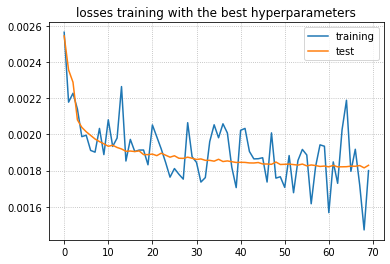

In [ ]:
plt.plot(train_loss_record, label='training')
plt.plot(val_loss_record, label='test')
plt.legend()
plt.grid(linestyle=":")
plt.title("losses training with the best hyperparameters")
plt.show()

# Comparison on reconstructed samples

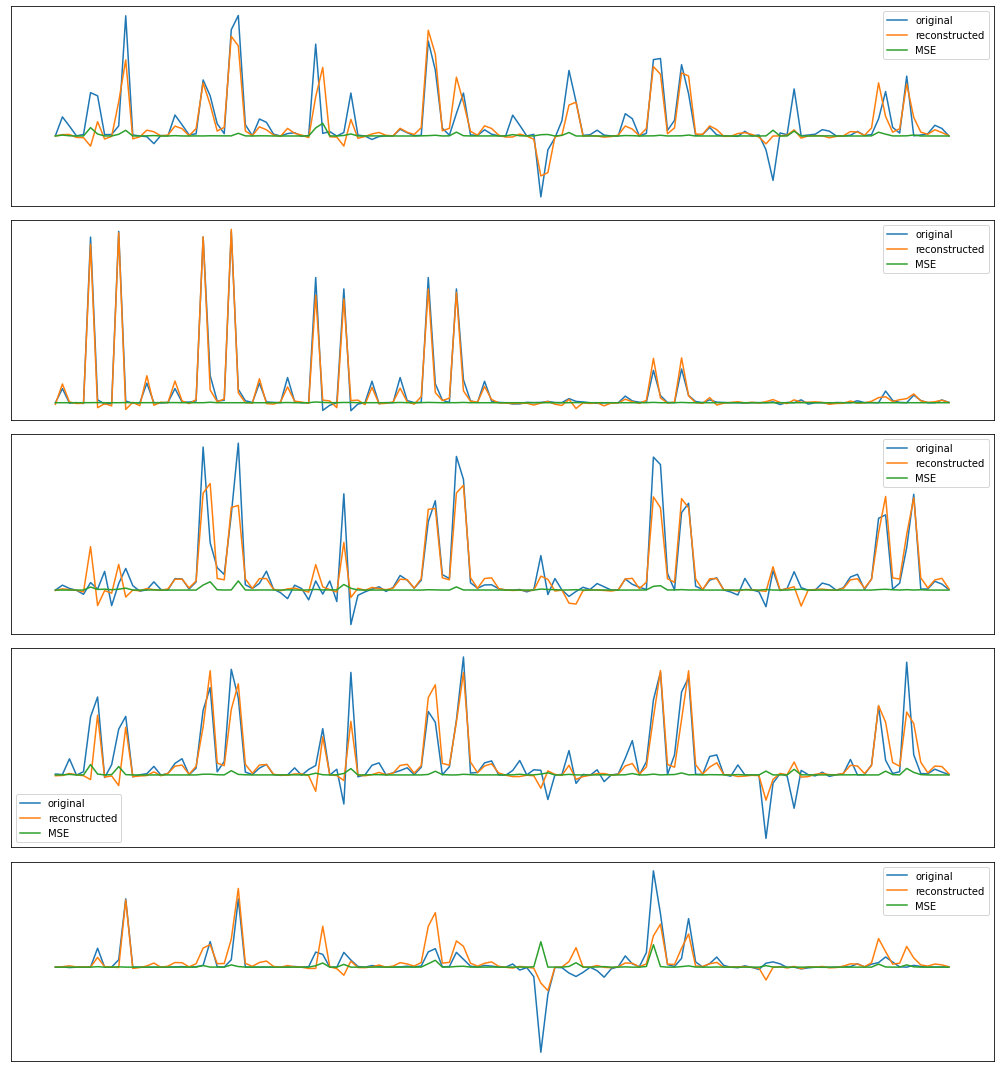

In [ ]:
best_encoder = encoder
best_decoder = decoder

rows = 5
fig, ax = plt.subplots(rows, 1, figsize=(14,15))
for i in range(rows):
    img = random.choice(train_dataset_reduced)
    img = img.unsqueeze(0).to(device)
    best_encoder.eval()
    best_decoder.eval()
    with torch.no_grad():
        rec_img  = best_decoder(best_encoder(img))
    ax[i].plot(img.cpu().squeeze().numpy().reshape(64,), label='original')
    ax[i].plot(rec_img.cpu().squeeze().numpy().reshape(64,), label='reconstructed')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].plot((rec_img.cpu().squeeze().numpy().reshape(64,)-img.cpu().squeeze().numpy().reshape(64,))**2, label='MSE')
    ax[i].legend()

plt.tight_layout()